In [1]:
from utils import plot_results_3d, plot_results_2d
from utils import partial_obs_operator, DATASET_INFO, get_mean_std
from torch.utils.data import Dataset, DataLoader

from networks import ComplexAttentionModel, AttentionModel
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import torch
from localization import plot_GC, pairwise_distances
import os

In [ ]:
Climatology_1 = [3.62] * 7
Climatology_std_1 = [0.01] * 7
OptInterp_1 = [2.94] * 7
OptInterp_std_1 = [0.02] * 7
Var3D_1 = [3.18] * 7
Var3D_std_1 = [0.08] * 7

Climatology_2 = [3.62] * 7
Climatology_std_2 = [0.01] * 7
OptInterp_2 = [2.92] * 7
OptInterp_std_2 = [0.02] * 7
Var3D_2 = [3.15] * 7
Var3D_std_2 = [0.08] * 7

def replace_nan_with_value(lst, value=6):
    return [value if np.isnan(x) else x for x in lst]

file_path = 'save/benchmark/benchmarks_L96.csv'
df = pd.read_csv(file_path, usecols=['method', 'sigma_y', 'best_mean', 'best_var'])

result_dict = {}

methods = df['method'].unique()

for method in methods:
    method_data = df[df['method'] == method]
    
    result_dict[method] = {
        "1_rmse": replace_nan_with_value(method_data[method_data['sigma_y'] == 1]['best_mean'].tolist()),
        "1_std": method_data[method_data['sigma_y'] == 1]['best_var'].tolist(),
        "0.7_rmse": replace_nan_with_value(method_data[method_data['sigma_y'] == 0.7]['best_mean'].tolist()),
        "0.7_std": method_data[method_data['sigma_y'] == 0.7]['best_var'].tolist(),
    }

# $\sigma_y=1$

In [3]:
ens_list = [5, 10, 15, 20, 40, 60, 100]
method_names = [r'EnST', r'EnST FT']
folder_names = ['2024-11-08_17-08lorenz96_1.0_10_60_8192_EnST_normalized_l2',
                '2024-11-11_09-53lorenz96_1.0_20_50_4096_EnST_tuned_normalized_l2']

n = len(method_names)
mean_nn_list = [[] for _ in range(n)]
std_nn_list = [[] for _ in range(n)]
lenkf_mean_nn_list = [[] for _ in range(n)]
for j in range(n):
    for i in ens_list:
        data_dic = torch.load(f'save/{folder_names[j]}/output_records_{i}.pt')
        mean, std = get_mean_std(torch.mean(data_dic['nn']['loss'],dim=0))
        mean_nn_list[j].append(mean)
        std_nn_list[j].append(std)


/tmp/ipykernel_32048/567783631.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_dic = torch.load(f'save/{folder_names[j]}/output_records_{i}.pt')


In [4]:
print(mean_nn_list)
print(std_nn_list)

[[2.032724142074585, 1.4487931728363037, 1.4216649532318115, 1.4155066013336182, 1.4219454526901245, 1.4296108484268188, 1.4388521909713745], [1.5843995809555054, 1.439348578453064, 1.3569684028625488, 1.297895073890686, 1.172090768814087, 1.1243693828582764, 1.0817919969558716]]
[[0.04972687363624573, 0.04723113775253296, 0.04388822987675667, 0.040892235934734344, 0.03753997012972832, 0.03913484141230583, 0.03742652013897896], [0.04204889014363289, 0.04618676379323006, 0.047980308532714844, 0.04402219504117966, 0.045764461159706116, 0.046124279499053955, 0.04354718700051308]]


In [5]:
import datetime
save_fig_name = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M')

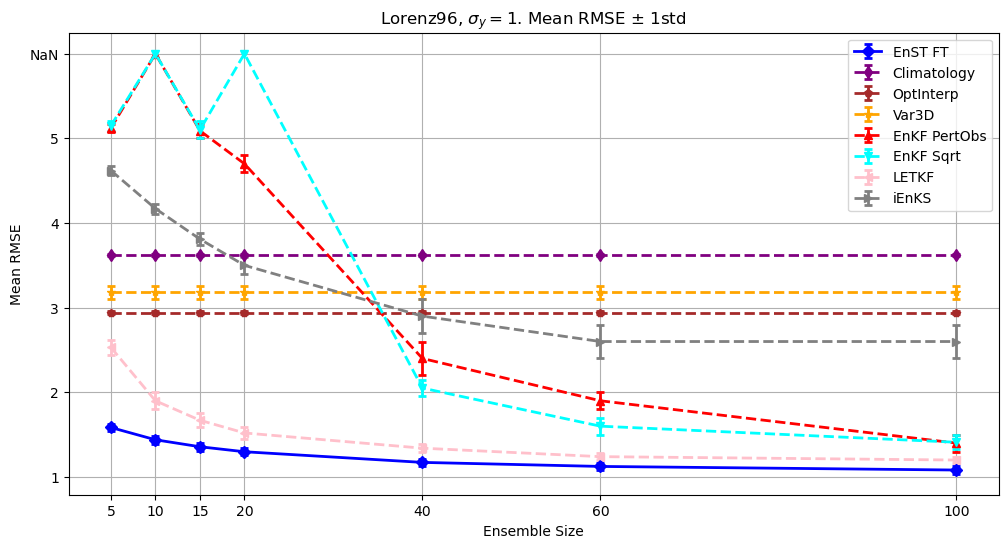

In [6]:
x_inds = [5, 10, 15, 20, 40, 60, 100]

# Plotting with figure adjustment
plt.figure(figsize=(12, 6))  # Adjusted figure size to elongate x-axis
# plt.plot(x_inds, mean_nn_list[0], linestyle='-', marker='o', markersize=10, color='navy', linewidth=3, label=method_names[0])  
# plt.plot(x_inds, mean_nn_list[1], linestyle='-', marker='s', markersize=10, color='darkgreen', linewidth=3, label=method_names[1]) 
# plt.plot(x_inds, mean_nn_list[2], linestyle='-', marker='^', markersize=10, color='darkred', linewidth=3, label=method_names[2])  
plt.errorbar(x_inds, mean_nn_list[1], yerr=std_nn_list[1], linestyle='-', marker='D', capsize=3, capthick=2,markersize=6, color='blue', linewidth=2, label=method_names[1])   
plt.errorbar(x_inds, Climatology_1, yerr=Climatology_std_1, linestyle='--', marker='d', capsize=3, capthick=2,markersize=6, color='purple', linewidth=2, label="Climatology")
plt.errorbar(x_inds, OptInterp_1, yerr=OptInterp_std_1, linestyle='--', marker='p', capsize=3, capthick=2,markersize=6, color='brown', linewidth=2, label="OptInterp")
plt.errorbar(x_inds, Var3D_1, yerr=Var3D_std_1, linestyle='--', marker='*', capsize=3, capthick=2,markersize=6, color='orange', linewidth=2, label="Var3D")
plt.errorbar(x_inds, result_dict['EnKF_PertObs']["1_rmse"], yerr=result_dict['EnKF_PertObs']["1_std"], linestyle='--', marker='^', capsize=3, capthick=2,markersize=6, color='red', linewidth=2, label="EnKF PertObs")
plt.errorbar(x_inds, result_dict['EnKF_Sqrt']["1_rmse"], yerr=result_dict['EnKF_Sqrt']["1_std"], linestyle='--', marker='v', capsize=3, capthick=2,markersize=6, color='cyan', linewidth=2, label="EnKF Sqrt")
plt.errorbar(x_inds, result_dict['LETKF']["1_rmse"], yerr=result_dict['LETKF']["1_std"], linestyle='--', marker='<', capsize=3, capthick=2,markersize=6, color='pink', linewidth=2, label="LETKF")
plt.errorbar(x_inds, result_dict['iEnKS']["1_rmse"], yerr=result_dict['iEnKS']["1_std"], linestyle='--', marker='>', capsize=3, capthick=2,markersize=6, color='gray', linewidth=2, label="iEnKS")


# Customizing y-axis ticks to [1, 2, 3, ..., 7] with 7 replaced by "NaN"
y_ticks = list(range(1, 7))  # Set y-ticks from 1 to 7
new_y_ticks = ["NaN" if y == 6 else y for y in y_ticks]  # Replace 7 with NaN
plt.yticks(ticks=y_ticks, labels=new_y_ticks)

# Adjusting legend location to outside the plot on the upper right
plt.legend(loc='upper right')

# Adding title, labels, and setting x-ticks
plt.title(r"Lorenz96, $\sigma_y=1$. Mean RMSE $\pm$ 1std")
plt.xlabel("Ensemble Size")
plt.ylabel("Mean RMSE")
plt.xticks([5, 10, 15, 20, 40, 60, 100])
plt.grid(True)

# Display plot
plt.savefig(os.path.join('save/figures', f"{save_fig_name}_10.png"), bbox_inches="tight", dpi=200)
plt.show()

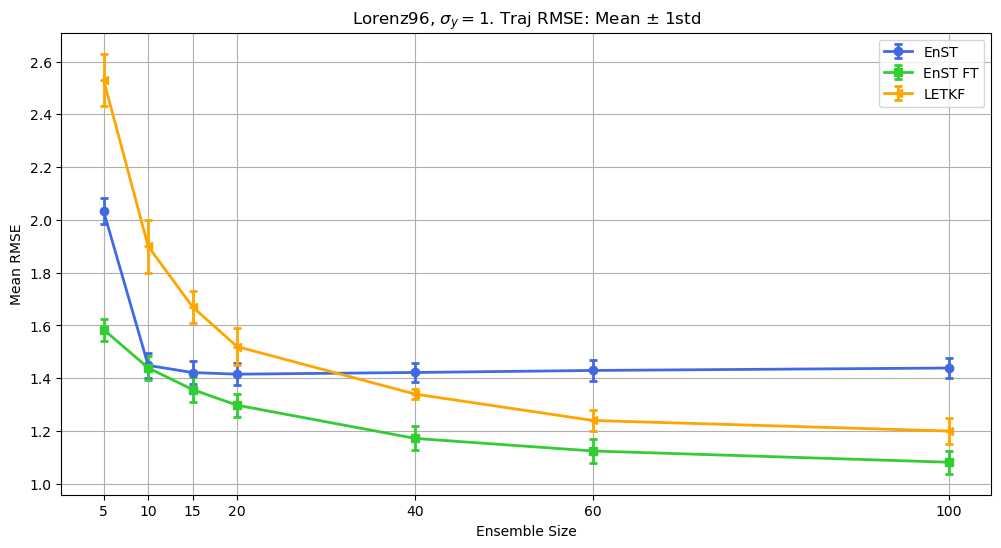

In [7]:
x_inds = [5, 10, 15, 20, 40, 60, 100]

# Plotting with figure adjustment
plt.figure(figsize=(12, 6))  # Adjusted figure size to elongate x-axis
plt.errorbar(x_inds, mean_nn_list[0], yerr=std_nn_list[0], linestyle='-', marker='o', markersize=6, capsize=3, capthick=2,color='royalblue', linewidth=2, label=method_names[0])  
plt.errorbar(x_inds, mean_nn_list[1], yerr=std_nn_list[1], linestyle='-', marker='s', markersize=6, capsize=3, capthick=2,color='limegreen', linewidth=2, label=method_names[1])   
plt.errorbar(x_inds, result_dict['LETKF']["1_rmse"], yerr=result_dict['LETKF']["0.7_std"], linestyle='-', marker='<', markersize=6, capsize=3, capthick=2,color='orange', linewidth=2, label="LETKF")



# Adjusting legend location to outside the plot on the upper right
plt.legend(loc='upper right')

# Adding title, labels, and setting x-ticks
plt.title(r"Lorenz96, $\sigma_y=1$. Traj RMSE: Mean $\pm$ 1std")
plt.xlabel("Ensemble Size")
plt.ylabel("Mean RMSE")
plt.xticks([5, 10, 15, 20, 40, 60, 100])
plt.grid(True)

# Display plot
plt.savefig(os.path.join('save/figures', f"{save_fig_name}_10_ours_and_LETKF.png"), bbox_inches="tight", dpi=200)
plt.show()

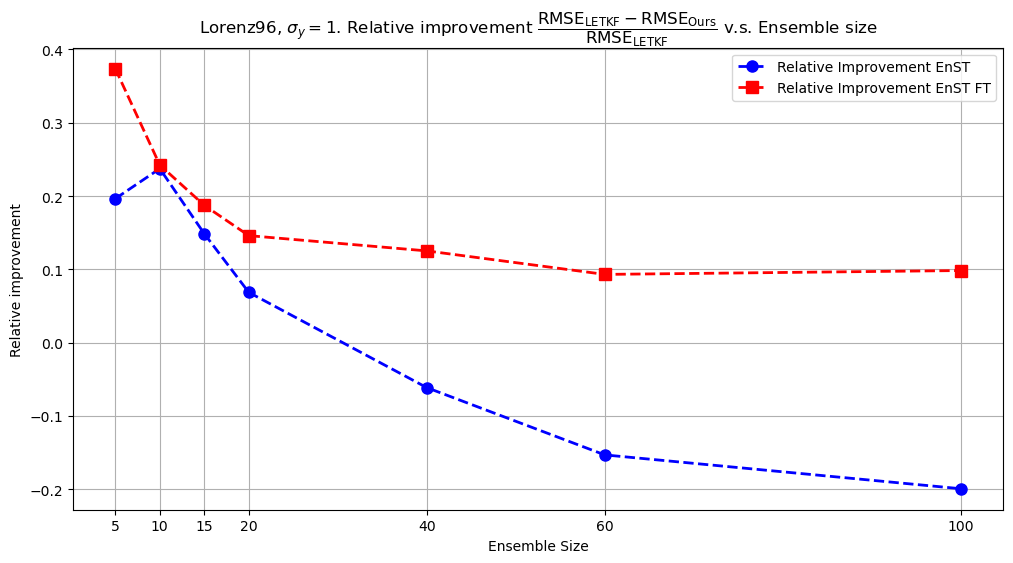

In [8]:
x_inds = [5, 10, 15, 20, 40, 60, 100]

relative_imp_1 = (torch.tensor(result_dict['LETKF']["1_rmse"]) - torch.tensor(mean_nn_list[0])) / torch.tensor(result_dict['LETKF']["1_rmse"])
relative_imp_2 = (torch.tensor(result_dict['LETKF']["1_rmse"]) - torch.tensor(mean_nn_list[1])) / torch.tensor(result_dict['LETKF']["1_rmse"])

# Plotting with figure adjustment
plt.figure(figsize=(12, 6))  # Adjusted figure size to elongate x-axis
plt.plot(x_inds, relative_imp_1, linestyle='--', marker='o', markersize=8, color='blue', linewidth=2, label="Relative Improvement EnST")  # Enhanced line
plt.plot(x_inds, relative_imp_2, linestyle='--', marker='s', markersize=8, color='red', linewidth=2, label="Relative Improvement EnST FT")  # Enhanced line

# Customizing y-axis ticks to [1, 2, 3, ..., 7] with 7 replaced by "NaN"
# y_ticks = list(range(1, 7))  # Set y-ticks from 1 to 7
# new_y_ticks = ["NaN" if y == 6 else y for y in y_ticks]  # Replace 7 with NaN
# plt.yticks(ticks=y_ticks, labels=new_y_ticks)

# Adjusting legend location to outside the plot on the upper right
plt.legend(loc='upper right')

# Adding title, labels, and setting x-ticks
plt.title(r"Lorenz96, $\sigma_y=1$. Relative improvement $\dfrac{\mathrm{RMSE}_{\mathrm{LETKF}} - \mathrm{RMSE}_{\mathrm{Ours}}}{\mathrm{RMSE}_{\mathrm{LETKF}}}$ v.s. Ensemble size")

plt.xlabel("Ensemble Size")
plt.ylabel("Relative improvement")
plt.xticks([5, 10, 15, 20, 40, 60, 100])
plt.grid(True)

# Display plot
plt.savefig(os.path.join('save/figures', f"{save_fig_name}_reimp.png"), bbox_inches="tight", dpi=200)
plt.show()

# $\sigma_y=0.7$

In [9]:
ens_list = [5, 10, 15, 20, 40, 60, 100]
method_names = [r'EnST', r'EnST FT']
folder_names = ['2024-11-11_10-47lorenz96_0.7_10_60_8192_EnST_normalized_l2',
                '2024-11-11_15-28lorenz96_0.7_20_50_4096_EnST_tuned_normalized_l2']

n = len(method_names)
mean_nn_list = [[] for _ in range(n)]
std_nn_list = [[] for _ in range(n)]
lenkf_mean_nn_list = [[] for _ in range(n)]
for j in range(n):
    for i in ens_list:
        data_dic = torch.load(f'save/{folder_names[j]}/output_records_{i}.pt')
        mean, std = get_mean_std(torch.mean(data_dic['nn']['loss'],dim=0))
        mean_nn_list[j].append(mean)
        std_nn_list[j].append(std)

print(mean_nn_list)
print(std_nn_list)
import datetime
save_fig_name = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M')

/tmp/ipykernel_32048/1872873712.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_dic = torch.load(f'save/{folder_names[j]}/output_records_{i}.pt')


[[1.6846206188201904, 1.0580686330795288, 0.9985369443893433, 0.9955160021781921, 1.0029423236846924, 1.0198543071746826, 1.0345780849456787], [1.278271198272705, 1.0613009929656982, 0.9313706159591675, 0.8521217703819275, 0.7324049472808838, 0.6877599954605103, 0.6566546559333801]]
[[0.05607190728187561, 0.04684290289878845, 0.04538207873702049, 0.041343845427036285, 0.036562081426382065, 0.036437880247831345, 0.03871193528175354], [0.053839061409235, 0.050134047865867615, 0.04942081868648529, 0.04121854156255722, 0.03371567651629448, 0.03207254409790039, 0.028964901342988014]]


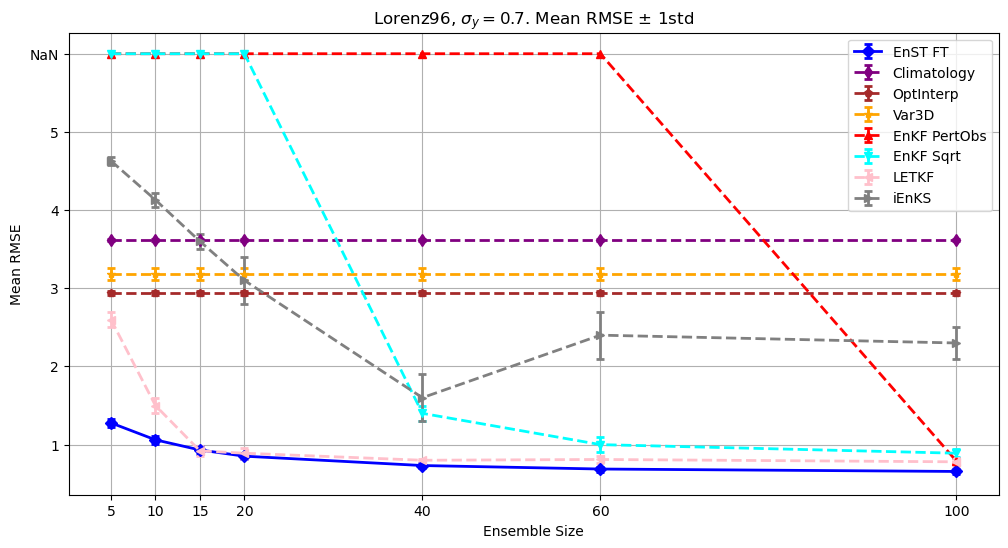

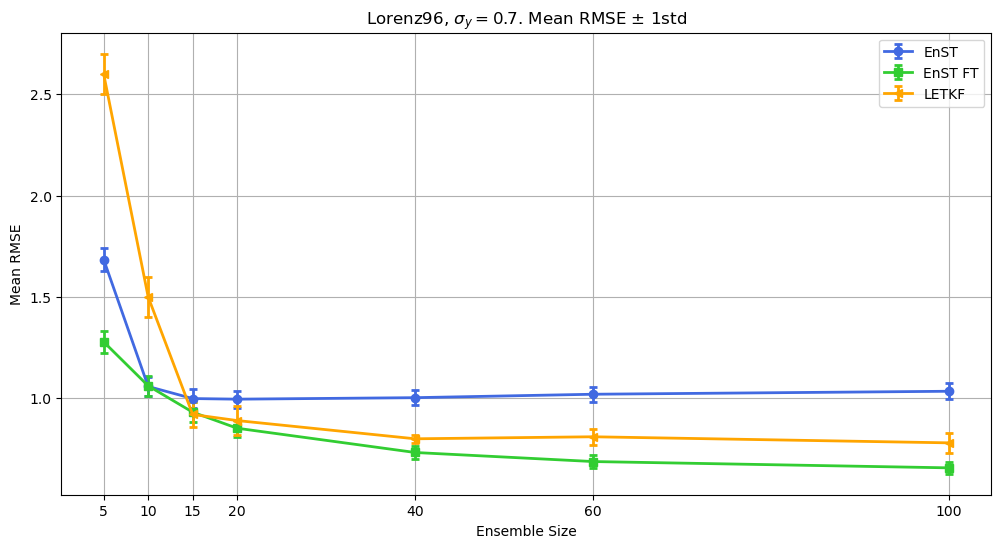

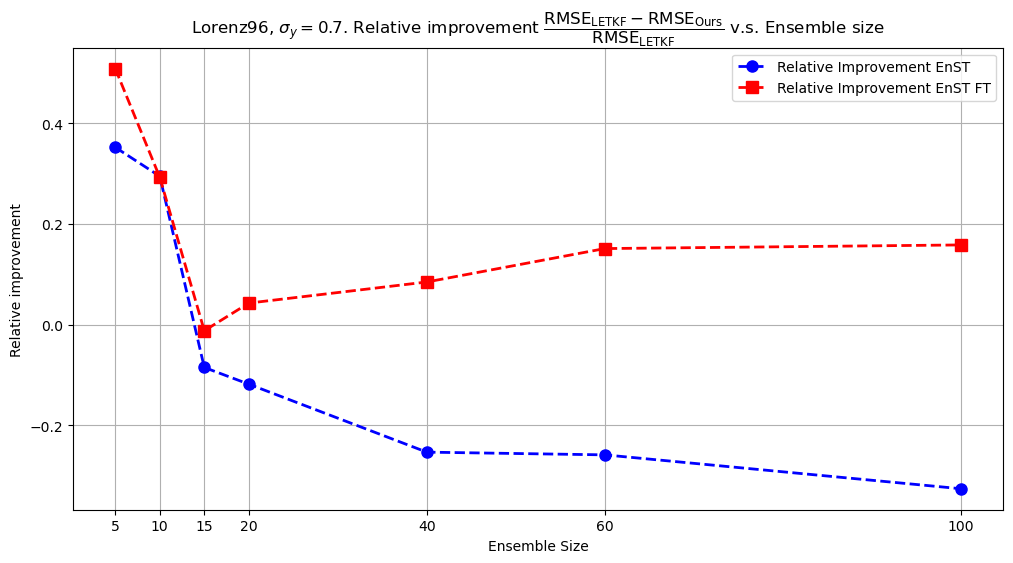

In [10]:
x_inds = [5, 10, 15, 20, 40, 60, 100]

# Plotting with figure adjustment
plt.figure(figsize=(12, 6))  # Adjusted figure size to elongate x-axis
plt.errorbar(x_inds, mean_nn_list[1], yerr=std_nn_list[1], linestyle='-', marker='D', capsize=3, capthick=2,markersize=6, color='blue', linewidth=2, label=method_names[1])   
plt.errorbar(x_inds, Climatology_1, yerr=Climatology_std_1, linestyle='--', marker='d', capsize=3, capthick=2,markersize=6, color='purple', linewidth=2, label="Climatology")
plt.errorbar(x_inds, OptInterp_1, yerr=OptInterp_std_1, linestyle='--', marker='p', capsize=3, capthick=2,markersize=6, color='brown', linewidth=2, label="OptInterp")
plt.errorbar(x_inds, Var3D_1, yerr=Var3D_std_1, linestyle='--', marker='*', capsize=3, capthick=2,markersize=6, color='orange', linewidth=2, label="Var3D")
plt.errorbar(x_inds, result_dict['EnKF_PertObs']["0.7_rmse"], yerr=result_dict['EnKF_PertObs']["0.7_std"], linestyle='--', marker='^', capsize=3, capthick=2,markersize=6, color='red', linewidth=2, label="EnKF PertObs")
plt.errorbar(x_inds, result_dict['EnKF_Sqrt']["0.7_rmse"], yerr=result_dict['EnKF_Sqrt']["0.7_std"], linestyle='--', marker='v', capsize=3, capthick=2,markersize=6, color='cyan', linewidth=2, label="EnKF Sqrt")
plt.errorbar(x_inds, result_dict['LETKF']["0.7_rmse"], yerr=result_dict['LETKF']["0.7_std"], linestyle='--', marker='<', capsize=3, capthick=2,markersize=6, color='pink', linewidth=2, label="LETKF")
plt.errorbar(x_inds, result_dict['iEnKS']["0.7_rmse"], yerr=result_dict['iEnKS']["0.7_std"], linestyle='--', marker='>', capsize=3, capthick=2,markersize=6, color='gray', linewidth=2, label="iEnKS")


# Customizing y-axis ticks to [1, 2, 3, ..., 7] with 7 replaced by "NaN"
y_ticks = list(range(1, 7))  # Set y-ticks from 1 to 7
new_y_ticks = ["NaN" if y == 6 else y for y in y_ticks]  # Replace 7 with NaN
plt.yticks(ticks=y_ticks, labels=new_y_ticks)

# Adjusting legend location to outside the plot on the upper right
plt.legend(loc='upper right')

# Adding title, labels, and setting x-ticks
plt.title(r"Lorenz96, $\sigma_y=0.7$. Mean RMSE $\pm$ 1std")
plt.xlabel("Ensemble Size")
plt.ylabel("Mean RMSE")
plt.xticks([5, 10, 15, 20, 40, 60, 100])
plt.grid(True)

# Display plot
plt.savefig(os.path.join('save/figures', f"{save_fig_name}_10.png"), bbox_inches="tight", dpi=200)
plt.show()
x_inds = [5, 10, 15, 20, 40, 60, 100]

# Plotting with figure adjustment
plt.figure(figsize=(12, 6))  # Adjusted figure size to elongate x-axis
plt.errorbar(x_inds, mean_nn_list[0], yerr=std_nn_list[0], linestyle='-', marker='o', markersize=6, capsize=3, capthick=2,color='royalblue', linewidth=2, label=method_names[0])  
plt.errorbar(x_inds, mean_nn_list[1], yerr=std_nn_list[1], linestyle='-', marker='s', markersize=6, capsize=3, capthick=2,color='limegreen', linewidth=2, label=method_names[1]) 
plt.errorbar(x_inds, result_dict['LETKF']["0.7_rmse"], yerr=result_dict['LETKF']["0.7_std"], linestyle='-', marker='<', markersize=6, capsize=3, capthick=2,color='orange', linewidth=2, label="LETKF")



# Adjusting legend location to outside the plot on the upper right
plt.legend(loc='upper right')

# Adding title, labels, and setting x-ticks
plt.title(r"Lorenz96, $\sigma_y=0.7$. Mean RMSE $\pm$ 1std")
plt.xlabel("Ensemble Size")
plt.ylabel("Mean RMSE")
plt.xticks([5, 10, 15, 20, 40, 60, 100])
plt.grid(True)

# Display plot
plt.savefig(os.path.join('save/figures', f"{save_fig_name}_10_ours_and_LETKF.png"), bbox_inches="tight", dpi=200)
plt.show()
x_inds = [5, 10, 15, 20, 40, 60, 100]

relative_imp_1 = (torch.tensor(result_dict['LETKF']["0.7_rmse"]) - torch.tensor(mean_nn_list[0])) / torch.tensor(result_dict['LETKF']["0.7_rmse"])
relative_imp_2 = (torch.tensor(result_dict['LETKF']["0.7_rmse"]) - torch.tensor(mean_nn_list[1])) / torch.tensor(result_dict['LETKF']["0.7_rmse"])

# Plotting with figure adjustment
plt.figure(figsize=(12, 6))  # Adjusted figure size to elongate x-axis
plt.plot(x_inds, relative_imp_1, linestyle='--', marker='o', markersize=8, color='blue', linewidth=2, label="Relative Improvement EnST")  # Enhanced line
plt.plot(x_inds, relative_imp_2, linestyle='--', marker='s', markersize=8, color='red', linewidth=2, label="Relative Improvement EnST FT")  # Enhanced line

# Customizing y-axis ticks to [1, 2, 3, ..., 7] with 7 replaced by "NaN"
# y_ticks = list(range(1, 7))  # Set y-ticks from 1 to 7
# new_y_ticks = ["NaN" if y == 6 else y for y in y_ticks]  # Replace 7 with NaN
# plt.yticks(ticks=y_ticks, labels=new_y_ticks)

# Adjusting legend location to outside the plot on the upper right
plt.legend(loc='upper right')

# Adding title, labels, and setting x-ticks
plt.title(r"Lorenz96, $\sigma_y=0.7$. Relative improvement $\dfrac{\mathrm{RMSE}_{\mathrm{LETKF}} - \mathrm{RMSE}_{\mathrm{Ours}}}{\mathrm{RMSE}_{\mathrm{LETKF}}}$ v.s. Ensemble size")

plt.xlabel("Ensemble Size")
plt.ylabel("Relative improvement")
plt.xticks([5, 10, 15, 20, 40, 60, 100])
plt.grid(True)

# Display plot
plt.savefig(os.path.join('save/figures', f"{save_fig_name}_reimp.png"), bbox_inches="tight", dpi=200)
plt.show()